Run this initial code block

In [1]:
import pandas as pd
import boto3


boto3 setup:

In [2]:
s3 = boto3.resource('s3')

s3_obj = s3.Bucket("spotify-song-recommender-data").Object('tracks_features.csv').get()

song_data = pd.read_csv(s3_obj['Body'])

song_data.describe()
# song_data.head()


,track_number,disc_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
count,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06
mean,7.656352e+00,1.055906e+00,4.930565e-01,5.095363e-01,5.194151e+00,-1.180870e+01,6.714595e-01,8.438219e-02,4.467511e-01,2.828605e-01,2.015994e-01,4.279866e-01,1.176344e+02,2.488399e+05,3.832494e+00,2.007328e+03
std,5.994977e+00,2.953752e-01,1.896694e-01,2.946839e-01,3.536731e+00,6.982132e+00,4.696827e-01,1.159914e-01,3.852014e-01,3.762844e-01,1.804591e-01,2.704846e-01,3.093705e+01,1.622104e+05,5.611826e-01,1.210117e+01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00
25%,3.000000e+00,1.000000e+00,3.560000e-01,2.520000e-01,2.000000e+00,-1.525400e+01,0.000000e+00,3.510000e-02,3.760000e-02,7.600000e-06,9.680000e-02,1.910000e-01,9.405400e+01,1.740900e+05,4.000000e+00,2.002000e+03
50%,7.000000e+00,1.000000e+00,5.010000e-01,5.240000e-01,5.000000e+00,-9.791000e+00,1.000000e+00,4.460000e-02,3.890000e-01,8.080000e-03,1.250000e-01,4.030000e-01,1.167260e+02,2.243390e+05,4.000000e+00,2.009000e+03
75%,1.000000e+01,1.000000e+00,6.330000e-01,7.660000e-01,8.000000e+00,-6.717000e+00,1.000000e+00,7.230000e-02,8.610000e-01,7.190000e-01,2.450000e-01,6.440000e-01,1.370460e+02,2.858400e+05,4.000000e+00,2.015000e+03
max,5.000000e+01,1.300000e+01,1.000000e+00,1.000000e+00,1.100000e+01,7.234000e+00,1.000000e+00,9.690000e-01,9.960000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.489340e+02,6.061090e+06,5.000000e+00,2.020000e+03


In [3]:
song_data.head()

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

In [28]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mini_batch_kmeans', MiniBatchKMeans(n_clusters=60))
])

In [24]:
song_data.columns
features = ['tempo', 'loudness', 'energy', 'danceability', 'liveness', 'speechiness', 'acousticness', 'instrumentalness', 'valence']
X = song_data[features]


In [29]:
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mini_batch_kmeans', MiniBatchKMeans(n_clusters=60))])

Identifying Optimal Number of Clusters (Elbow Plot)

In [11]:
def optimize_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias,'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Interia')
    plt.grid(True)
    plt.show()


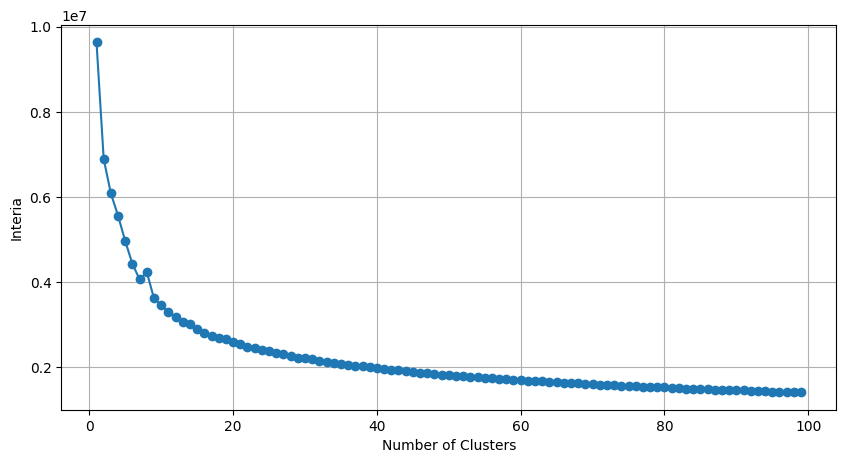

In [12]:
optimize_k_means(X_scaled, 100)

Applying K Means and MiniBatch Clustering

In [15]:
kmeans = KMeans(n_clusters=60, random_state=1)
mini_Batch_Kmeans = MiniBatchKMeans(n_clusters=60, random_state=1)

In [16]:
kmeans.fit(X_scaled)
mini_Batch_Kmeans.fit(X_scaled)

MiniBatchKMeans(n_clusters=60, random_state=1)

In [ ]:
song_data['miniKmean_60'] = mini_Batch_Kmeans.labels_


In [18]:
song_data

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,miniKmean_60
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02,35
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02,2
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02,29
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02,25
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204020,0EsMifwUmMfJZxzoMPXJKZ,Gospel of Juke,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],2,1,False,0.264,...,0.00935,0.002240,0.3370,0.415,159.586,276213,4.0,2014,2014-01-09,48
1204021,2WSc2TB1CSJgGE0PEzVeiu,Prism Visions,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],3,1,False,0.796,...,0.10400,0.644000,0.0749,0.781,121.980,363179,4.0,2014,2014-01-09,39
1204022,6iProIgUe3ETpO6UT0v5Hg,Tokyo 360,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],4,1,False,0.785,...,0.03040,0.918000,0.0664,0.467,121.996,385335,4.0,2014,2014-01-09,47
1204023,37B4SXC8uoBsUyKCWnhPfX,Yummy!,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],5,1,False,0.665,...,0.00007,0.776000,0.1170,0.227,124.986,324455,4.0,2014,2014-01-09,47


In [19]:
clusteredData = song_data[['id', 'miniKmean_60']].to_csv("cluster_labels", index=False)

In [43]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=song_data['kmean_10'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clusters (PCA-reduced)')
plt.colorbar(scatter, label='Cluster')
plt.show()

KeyError: 'kmean_10'

<Figure size 800x600 with 0 Axes>

In [15]:
# unique_genres = set()
# for genre_list in song_data['Genre']:
#     genres = [g.strip() for g in genre_list.split(',')]
#     unique_genres.update(genres)

# print(sorted(unique_genres))
print(song_data['genre'].value_counts().head(35))

KeyError: 'genre'

In [ ]:
unique_genres = set()

for genre_str in song_data['Genre']:
    genres = [g.strip() for g in genre_str.split(',')]
    unique_genres.update(genres)

print(sorted(unique_genres))

In [ ]:
test_song = song_data.iloc[[4456]] # Best I Ever Had -Drake
print(test_song)


In [ ]:
test_song_cluster_id = test_song['miniKmean_60'].iloc[0]
cluster_list = song_data[song_data['miniKmean_60'] == test_song_cluster_id].copy()
print(len(cluster_list))
for songName in cluster_list['song']:
        print(f" - {songName}")

Computer Cosine similarity to the Cluster list

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
test_vector = test_song[features]
cluster_vectors = cluster_list[features]

similarities = cosine_similarity(test_vector, cluster_vectors)[0]
cluster_list['similarities'] = similarities

recommendations = cluster_list.sort_values(by='similarities', ascending=False)
print(recommendations[['artist', 'song', 'similarities', 'Genre', 'Popularity']].head(20))


In [30]:
import mlflow

In [31]:
mini_Batch_Kmeans = pipeline.named_steps['mini_batch_kmeans']

In [32]:
MLFLOW_TRACKING_URI="http://ec2-3-148-231-10.us-east-2.compute.amazonaws.com:5000/"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

with mlflow.start_run():
    mlflow.log_param("n_clusters", 60)
    mlflow.log_param("batch_size", mini_Batch_Kmeans.batch_size)
    mlflow.log_metric("inertia", mini_Batch_Kmeans.inertia_)

    mlflow.sklearn.log_model(pipeline, artifact_path="minibatch_kmeans_model")

2025/07/09 18:13:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run carefree-koi-570 at: http://ec2-3-148-231-10.us-east-2.compute.amazonaws.com:5000/#/experiments/0/runs/280ab65dc8e0410ab88d110d5b010100
🧪 View experiment at: http://ec2-3-148-231-10.us-east-2.compute.amazonaws.com:5000/#/experiments/0


Load MiniBatchKmeans model from MLflow

In [34]:
import mlflow.sklearn
MLFLOW_TRACKING_URI="http://ec2-3-148-231-10.us-east-2.compute.amazonaws.com:5000/"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)


model_uri = "runs:/280ab65dc8e0410ab88d110d5b010100/minibatch_kmeans_model"

model = mlflow.sklearn.load_model(model_uri)

print(model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mini_batch_kmeans', MiniBatchKMeans(n_clusters=60))])


To First 100 songs to json

In [4]:
first_100_songs = song_data.head(100)
first_100_songs.to_json('first_100_songs.json', orient='records', lines=True)

In [ ]:
import json

with open('test_songs.json', 'r') as file:
    data = json.load(file)

print(data)

[{'song_id': '68657172cda7042e29cdad27', 'tempo': 222.938, 'loudness': -31.895, 'energy': 0.51, 'danceability': 0.657, 'liveness': 0.032, 'speechiness': 0.03, 'acousticness': 0.234, 'instrumentalness': 0.731, 'valence': 0.186}, {'song_id': '68657172f73be2da51be5024', 'tempo': 89.227, 'loudness': -51.394, 'energy': 0.405, 'danceability': 0.515, 'liveness': 0.809, 'speechiness': 0.719, 'acousticness': 0.0152, 'instrumentalness': 0.036, 'valence': 0.78}, {'song_id': '68657172171b1d3a68fc8f4a', 'tempo': 71.548, 'loudness': -7.989, 'energy': 0.025, 'danceability': 0.733, 'liveness': 0.016, 'speechiness': 0.6722, 'acousticness': 0.5509, 'instrumentalness': 0.14, 'valence': 0.244}, {'song_id': '68657172258090583f6f66cd', 'tempo': 61.038, 'loudness': -2.58, 'energy': 0.632, 'danceability': 0.319, 'liveness': 0.96, 'speechiness': 0.7827, 'acousticness': 0.848, 'instrumentalness': 0.526, 'valence': 0.77}, {'song_id': '68657172fb62bced562af0f0', 'tempo': 186.53, 'loudness': -6.948, 'energy': 0.60

In [11]:
df = pd.DataFrame(data)
X = df.drop(columns=['song_id']).to_numpy()
predictions = model.predict(X)
print(predictions)


[43 43 52 52 52 52 52]
